# Bayesian Spam Email Classifier 


### Introduction
This project uses Bayesian classification to detect spam emails based on the SMS Spam Collection Dataset from UCI. By leveraging probabilities derived from the data, the model classifies messages as either "spam" or "ham" (not spam).



### Dataset
The dataset used is a text file with two columns:
- label: Indicates whether the message is "spam" or "ham."
- message: The content of the SMS message.


### Some of the Imports
- stopwords: To remove common words that don't add much meaning (e.g., "the", "and").
- word_tokenize: To split text into individual words (tokenization).
- WordNetLemmatizer: To reduce words to their base forms (lemmatization).
- train_test_split (from sklearn.model_selection): For splitting data into training and testing sets.







In [3]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import csv
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from math import log
from sklearn.model_selection import train_test_split

Convert the dataset into a usable format (CSV).


In [4]:


input_file_path = './data/SMSSpamCollection.txt'
output_file_path = './data/data.csv'

with open(input_file_path, 'r') as txt_file:
    lines = txt_file.readlines()

processed_data = []
for line in lines:
    label, message = line.strip().split('\t', 1)  # Only split at the first tab
    processed_data.append([label, message])

with open(output_file_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['label', 'message'])
    writer.writerows(processed_data)

print(f"Data has been successfully converted to {output_file_path}")


Data has been successfully converted to ./data/data.csv


### Preprocessing Steps
### 1. Binary Labeling:
Map the label column:
- "spam" → 1
- "ham" → 0



In [5]:
df = pd.read_csv("./data/data.csv", encoding="latin-1")
df.columns = ['label', 'message']

# Convert labels to numerical values
df['binary_label'] = df['label'].map({'ham': 0, 'spam': 1})

# Display first few rows
df.head()


,label,message,binary_label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


#### download the necessary NLTK datasets for stopwords, tokenization, and word lemmatization.








In [6]:
nltk.download('stopwords')
nltk.download('punkt_tab')  
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### 2.Tokenization and Data cleaning:
- Split messages into individual words for word-frequency analysis using the NLTK library.
- Remove unnecessary characters, stop words, and special symbols from the text.
- convert each word to their dictionary format (This is for not to analyse different forms of the same word many times)

In [7]:
# Preprocess function
def preprocess(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text.lower())
    words = [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word not in stop_words]
    return words


# Apply preprocessing
df['processed'] = df['message'].apply(preprocess)
df.head()


,label,message,binary_label,processed
0,ham,"Go until jurong point, crazy.. Available only ...",0,"[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,0,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,ham,U dun say so early hor... U c already then say...,0,"[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,"[nah, think, go, usf, life, around, though]"


# Probabilities
### Bayes' Theorem
- The spam detection system uses Bayes' theorem:
- 𝑃(spam∣words)=𝑃(words∣spam)⋅𝑃(spam)/𝑃(words)

​
 



### 1, Prior Probability:
Calculated the prior probability of spam and ham message
- The **prior probability** represents the initial belief about the probability of an email being spam or not before observing any features (e.g., specific words).

    - **Spam Prior**:  
  P(Spam) = {Number of spam emails} / {Total number of emails}
  

    - **Ham Prior**:  
  P(Ham) = {Number of ham emails} / {Total number of emails}




In [8]:
# Calculate priors
total_messages = len(df)
spam_messages = df['binary_label'].sum()
ham_messages = total_messages - spam_messages

P_spam = spam_messages / total_messages
P_ham = ham_messages / total_messages

print(f"P(spam): {P_spam:.2f}, P(ham): {P_ham:.2f}")


P(spam): 0.13, P(ham): 0.87


### 2. likelihood 
- P(word∣spam): Probability of a specific word given the message is spam.
    - P(word∣Spam)= Count of word w in spam emails+1 / (Total number of words in spam emails+Vocabulary size)
- P(word∣ham): Probability of a specific word given the message is ham.
    - P(word∣ham)= Count of word w in ham emails+1 / (Total number of words in ham emails+Vocabulary size)
    
- Split Messages: Separates words into spam_words and ham_words based on the binary_label (1 for spam, 0 for ham).
- Frequency Distribution: Counts occurrences of each word in spam and ham messages (spam_word_count, ham_word_count).
- Total Word Counts: Calculates total words in spam and ham messages.
- Unique Words: Finds unique words across both spam and ham, determining vocabulary_size.
- Likelihood Calculation: Uses Laplace smoothing to compute 
- Laplace smoothing
    - is a technique used to handle zero probabilities in probabilistic models like Naive Bayes. It adds a small constant (typically 1) to the count of each word to ensure no probability is zero, even for words not seen in the training data.
    The formula for Laplace smoothing is:
        P(word∣label)=(count(word)+1) / (total words in label+vocabulary size)
    - This approach prevents the model from assigning a probability of zero to unseen words, making the model more robust and generalizable.














In [10]:
# Split into spam and ham messages
spam_words = []
ham_words = []

for _, row in df.iterrows():
    if row['binary_label'] == 1:
        spam_words.extend(row['processed'])
    else:
        ham_words.extend(row['processed'])

# Create frequency distributions
spam_word_count = pd.Series(spam_words).value_counts()
ham_word_count = pd.Series(ham_words).value_counts()
# Total word counts
total_spam_words = sum(spam_word_count)
total_ham_words = sum(ham_word_count)

# Unique words across spam and ham
unique_words = set(spam_word_count.index).union(set(ham_word_count.index))
vocabulary_size = len(unique_words)

# Likelihood calculation with Laplace smoothing
def calculate_likelihood(word, word_count, total_words):
    return (word_count.get(word, 0) + 1) / (total_words + vocabulary_size)

# Example for the word "free"
print(f"P('free'|spam): {calculate_likelihood('free', spam_word_count, total_spam_words):.4f}")
print(f"P('free'|ham): {calculate_likelihood('free', ham_word_count, total_ham_words):.4f}")


P('free'|spam): 0.0115
P('free'|ham): 0.0013


### 3. Posterior Probability



The **posterior probability** is calculated using Bayes' Theorem:

$$
P(\text{Spam | Email}) = \frac{P(\text{Spam}) \cdot P(\text{Email | Spam})}{P(\text{Email})}
$$

For a given email, let \( w_1, w_2, \dots, w_n \) represent the words in the email. The posterior probability can be expressed as:

$$
P(\text{Spam | Email}) \propto P(\text{Spam}) \cdot P(w_1 | \text{Spam}) \cdot P(w_2 | \text{Spam}) \cdot \dots \cdot P(w_n | \text{Spam})
$$

Similarly, the posterior probability for non-spam (ham) is:

$$
P(\text{Ham | Email}) \propto P(\text{Ham}) \cdot P(w_1 | \text{Ham}) \cdot P(w_2 | \text{Ham}) \cdot \dots \cdot P(w_n | \text{Ham})
$$

### Decision Rule

The classification decision is based on comparing the posterior probabilities:

- Classify as **Spam** if:
  $$
  P(\text{Spam | Email}) > P(\text{Ham | Email})
  $$
- Otherwise, classify as **Ham**.



### after preprocessing 
- For each word in the email, the log likelihoods of the word given spam and ham are added to spam_prob and ham_prob.
- The email is classified as spam (1) if spam_prob is greater than ham_prob, otherwise it's classified as ham (0).
#### why do i use logarithim?
1.  Preventing Underflow:
Probabilities are often very small, especially when multiplying many of them together (as in Naive Bayes).
Multiplying many small probabilities can lead to underflow, where the result is too small for the computer to represent accurately.
Logarithms convert multiplication of probabilities into addition, which avoids this issue.
2. Simplifies Multiplication:
Instead of multiplying probabilities, we add their logarithms:
log(a×b)=log(a)+log(b)
This makes the computations more stable and easier to handle, especially for large datasets.
3. Better Numerical Stability:
Logarithmic operations are less sensitive to numerical precision issues compared to directly working with very small probabilities.
4. Efficient Calculation:
Adding numbers (logarithms of probabilities) is computationally more efficient than multiplying a long chain of small numbers.



In [11]:
# Predict function
def predict(email):
    words = preprocess(email)
    spam_prob = log(P_spam)
    ham_prob = log(P_ham)
    
    for word in words:
        spam_prob += log(calculate_likelihood(word, spam_word_count, total_spam_words))
        ham_prob += log(calculate_likelihood(word, ham_word_count, total_ham_words))
    
    return 1 if spam_prob >= ham_prob else 0 


- splits the dataset into 80% training and 20% testing data.
- The predict function is applied to each message in the test_data to generate predictions.
- Compares the predicted labels with the actual binary_label in test_data.
- Calculates the proportion of correct predictions and prints the accuracy percentage.


In [12]:
# Split data
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Evaluate the classifier
test_data['prediction'] = test_data['message'].apply(predict)
accuracy = (test_data['prediction'] == test_data['binary_label']).mean()
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 98.83%


### As We can see the model has almost 99% accuracy

### 4. Classify an email as spam or not based on the computed posterior probabilities.

In [13]:
messages = ["Congratulations! You've won a $1,000 gift card. Click here to claim your prize now!",
"URGENT: Your account has been compromised. Please verify your details immediately by clicking this link.",
"Get a loan with no credit check! Apply now and receive up to $10,000 instantly!",
"Hey, are we still meeting for coffee tomorrow at 10 AM?",
"Don't forget about the team meeting on Monday. Let me know if you need anything prepared.",
"Can you send me the notes from yesterday's class? I missed a few key points.",
"Happy Birthday! Hope you have a fantastic day filled with joy and laughter."
]
for message in messages:
    result = predict(message)
    if result == 1:
        print("Spam")
    else:
        print("Ham")

Spam
Spam
Spam
Ham
Ham
Ham
Ham


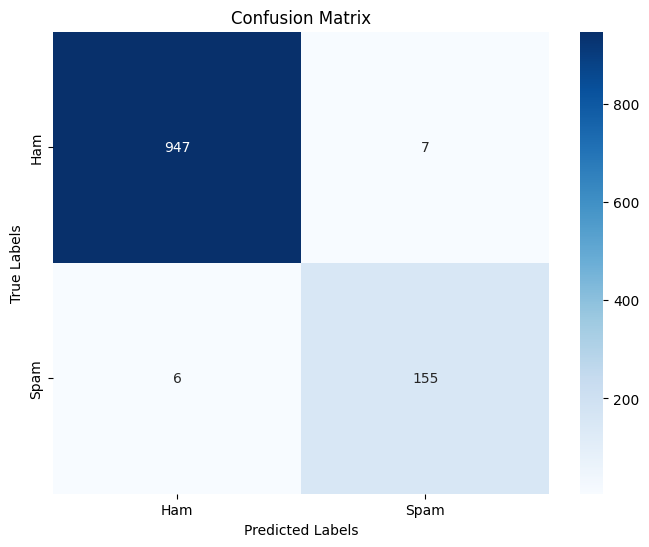

              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       954
        Spam       0.96      0.96      0.96       161

    accuracy                           0.99      1115
   macro avg       0.98      0.98      0.98      1115
weighted avg       0.99      0.99      0.99      1115



In [16]:
# Convert string labels to binary (0 for ham, 1 for spam)
test_data['binary_label'] = test_data['label'].map({'ham': 0, 'spam': 1})
test_data['prediction'] = test_data['message'].apply(predict)

# Calculate confusion matrix with binary labels
cm = confusion_matrix(test_data['binary_label'], test_data['prediction'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#classification report for detailed metrics
report = classification_report(test_data['binary_label'], test_data['prediction'], target_names=['Ham', 'Spam'])
print(report)


# Understanding the Confusion Matrix

The confusion matrix has the following layout:

| True Label \ Predicted Label | Ham               | Spam              |
|-----------------------------|-------------------|-------------------|
| **Ham**                     | True Negatives (TN) | False Positives (FP) |
| **Spam**                    | False Negatives (FN) | True Positives (TP) |

### Explanation of Terms:

- **True Negatives (TN)**: Non-spam emails correctly classified as non-spam.
- **False Positives (FP)**: Non-spam emails incorrectly classified as spam.
- **False Negatives (FN)**: Spam emails incorrectly classified as non-spam.
- **True Positives (TP)**: Spam emails correctly classified as spam.


# Classification Report

The classification report gives the precision, recall, and f1-score for each class, as well as their averages.

| Class  | Precision | Recall | F1-Score | Support |
|--------|-----------|--------|----------|---------|
| **Ham**| 0.99      | 0.99   | 0.99     | 954     |
| **Spam**| 0.96     | 0.96   | 0.96     | 161     |

**Accuracy**: 0.99 (99% of predictions were correct)

### Averages:

- **Macro Average**: 
    - Precision: 0.98
    - Recall: 0.98
    - F1-Score: 0.98

- **Weighted Average**: 
    - Precision: 0.99
    - Recall: 0.99
    - F1-Score: 0.99

### Explanation:
- **Precision**: The proportion of positive predictions that are actually correct.
    - For "Ham", 99% of the emails predicted as "Ham" were truly "Ham".
    - For "Spam", 96% of the emails predicted as "Spam" were truly "Spam".
  
- **Recall**: The proportion of actual positive cases that were correctly identified.
    - For "Ham", 99% of the true "Ham" emails were correctly classified.
    - For "Spam", 96% of the true "Spam" emails were correctly classified.
  
- **F1-Score**: The harmonic mean of precision and recall, providing a balanced metric.
    - Both for "Ham" and "Spam", the F1-scores are very high, indicating a good balance between precision and recall.

- **Support**: The number of occurrences of each class in the dataset.
    - There are 954 "Ham" messages and 161 "Spam" messages in the dataset.

The accuracy and weighted averages reflect the high performance of the spam classifier, especially for the "Ham" category, but also with a slight trade-off in precision/recall for "Spam".
